In [1]:
import numpy as np
from scipy.io import loadmat
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import clear_output
import imageio
import os

from scipy.io import savemat, loadmat
from scipy.ndimage import gaussian_filter1d as gf1d


In [2]:
def RBF(d,lmbda):
    return np.exp(-d**2/2/lmbda**2)

def mldivide(A,B):
    return np.linalg.pinv(A).dot(B)
    
def sm_GP(qq,f,lmbda,sigma):
    d_ij = qq.reshape(len(qq),1) - qq.reshape(1,len(qq))
    
    K = RBF(d_ij,lmbda)
    K_s = K
    K_y = K + np.eye(len(qq))*sigma**2
    
    y = f
    L = np.linalg.cholesky(K_y)

    alpha = mldivide(L.T,mldivide(L,y))
    E = K_s.T@alpha
    
    return E

In [5]:
#### Meshgrid ####
n_grid = 100
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z) 

# calculate scattering function
box_size = 2
n_grid_scale = 256
scale = n_grid_scale/r_grid[0].shape[0]
dq = 2*np.pi/box_size
qq = np.arange(n_grid_scale/2)*dq

#################################
S_q_Grid = []
p_Grid = []
for i in range(10):
    #### load data ####
    filename = '../../training_set/alpha/fixed_phase/grid_ext/S_q_{}_ex.mat'.format(i)
    data = loadmat(filename)
    k_grid = data['k_grid']
    S_q_kxy = data['S_q_kxy']
    
    S_q_Grid.append(S_q_kxy)
    p_Grid.append(k_grid)

for i in range(10):
    #### load data ####
    filename = '../../training_set/alpha/fixed_phase/grid_ext/S_q_{}.5_ex.mat'.format(i)
    data = loadmat(filename)
    k_grid = data['k_grid']
    S_q_kxy = data['S_q_kxy']
    
    S_q_Grid.append(S_q_kxy)
    p_Grid.append(k_grid)

S_q_Grid = np.array(S_q_Grid).reshape(100*len(p_Grid),128)[:,1:-1].astype(np.float32)
p_Grid = np.array(p_Grid).reshape(100*len(p_Grid),3)
S_q_sm_Grid = np.exp(np.array([gf1d(f,1,mode='nearest') for f in np.log(S_q_Grid)])).astype(np.float32)
log_S_q_Grid = np.log(S_q_Grid)
log_S_q_sm_Grid = np.log(S_q_sm_Grid)

ave_log_S_q_Grid = np.mean(log_S_q_sm_Grid,axis=0)

k_z = p_Grid[:,0].astype(np.float32)
alpha = p_Grid[:,1].astype(np.float32)
kappa = p_Grid[:,2].astype(np.float32)
logkappa = np.log(kappa).astype(np.float32)
set_k_z = np.unique(k_z)
set_alpha = np.unique(alpha)
set_kappa = np.flip(np.unique(kappa))

print('\nk_z in')
print(set_k_z)
print('\nalpha in')
print(set_alpha)
print('\nkappa in')
print(set_kappa)

#################################
S_q_Rand = []
p_Rand = []
for i in range(10):
    #### load data ####
    filename = '../../training_set/alpha/fixed_phase/rand_ext/S_q_rand_{}.mat'.format(i)
    data = loadmat(filename)
    k_grid = data['k_grid']
    S_q_kxy = data['S_q_kxy']
    
    S_q_Rand.append(S_q_kxy)
    p_Rand.append(k_grid)

S_q_Rand = np.array(S_q_Rand).reshape(100*len(p_Rand),128)[:,1:-1]
p_Rand = np.array(p_Rand).reshape(100*len(p_Rand),3)
S_q_sm_Rand = np.exp(np.array([gf1d(f,1,mode='nearest') for f in np.log(S_q_Rand)]))
log_S_q_Rand = np.log(S_q_Rand)
log_S_q_sm_Rand = np.log(S_q_sm_Rand)

k_z_Rand = p_Rand[:,0].astype(np.float32)
alpha_Rand = p_Rand[:,1].astype(np.float32)
kappa_Rand = p_Rand[:,2].astype(np.float32)
logkappa_Rand = np.log(kappa_Rand)


k_z in
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]

alpha in
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]

kappa in
[128.          90.50967     64.          45.254833    32.
  22.627417    16.          11.313708     8.           5.656854
   4.           2.828427     2.           1.4142135    1.
   0.70710677   0.5          0.35355338   0.25         0.17677669]


In [17]:
k_z_mean = np.mean(k_z)
k_z_std = np.std(k_z)
k_z_z = (k_z-k_z_mean)/k_z_std

kappa_mean = np.mean(logkappa)
kappa_std = np.std(logkappa)
kappa_z = (logkappa-kappa_mean)/kappa_std

alpha_mean = np.mean(alpha)
alpha_std = np.std(alpha)
alpha_z = (alpha-alpha_mean)/alpha_std

k_z_Rand_mean = np.mean(k_z_Rand)
k_z_Rand_std = np.std(k_z_Rand)
k_z_Rand_z = (k_z_Rand-k_z_Rand_mean)/k_z_Rand_std

kappa_Rand_mean = np.mean(logkappa_Rand)
kappa_Rand_std = np.std(logkappa_Rand)
kappa_Rand_z = (logkappa_Rand-kappa_Rand_mean)/kappa_Rand_std

alpha_Rand_mean = np.mean(alpha_Rand)
alpha_Rand_std = np.std(alpha_Rand)
alpha_Rand_z = (alpha_Rand-alpha_Rand_mean)/alpha_Rand_std

parameters_zscore = 0
if parameters_zscore:
    parameters_train = np.array([k_z_z,kappa_z,alpha_z]).T
else:
    parameters_train = np.array([k_z,logkappa,alpha]).T

if parameters_zscore:
    parameters_test = np.array([k_z_Rand_z,kappa_Rand_z,alpha_Rand_z]).T
else:
    parameters_test = np.array([k_z_Rand,logkappa_Rand,alpha_Rand]).T

In [18]:
y_train = log_S_q_sm_Grid
x_train = parameters_train
print(y_train.shape)
print(x_train.shape)

# Add a column of ones to x to account for the bias term
x_train_bias = np.hstack([x_train, np.ones((x_train.shape[0], 1))])

# Initialize A and B
A = np.zeros((x_train.shape[1], y_train.shape[1]))
B = np.zeros(y_train.shape[1])

# For each target variable
for i in range(y_train.shape[1]):
    # Solve for A and B using least squares
    coef, _, _, _ = np.linalg.lstsq(x_train_bias, y_train[:, i], rcond=None)
    A[:, i] = coef[:-1]
    B[i] = coef[-1]

(2000, 126)
(2000, 3)


In [19]:
# indexing
def id_params(parameters):
    tol = 1e-6
    id_k_z = np.abs(k_z-parameters[0])<tol
    id_alpha = np.abs(alpha-parameters[1])<tol
    id_kappa = np.abs(kappa-parameters[2])<tol
    return np.where(id_k_z*id_alpha*id_kappa)[0][0]

# color
def color_params(parameters):
    k_z_reduced = (parameters[0]-1)/10
    alpha_reduced = parameters[1]/1
    kappa_reduced = np.log(128/parameters[2])/10
    return [k_z_reduced, kappa_reduced, alpha_reduced]

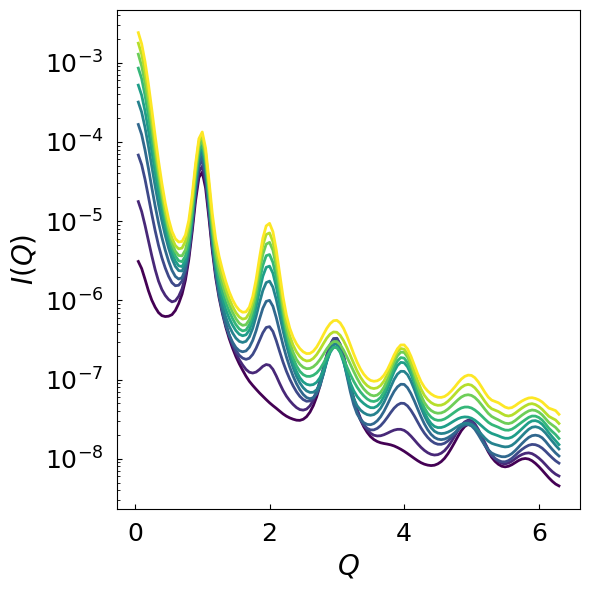

In [26]:
colormap = plt.cm.get_cmap('viridis')  # or any other colormap you like
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
for i, alpha_i in enumerate(set_alpha):
    parameters = [set_k_z[0],alpha_i,set_kappa[0]]
    index = id_params(parameters)
    
    color = colormap((alpha_i-np.min(x_train[:,2]))/(np.max(x_train[:,2])-np.min(x_train[:,2])))

    ax.plot(qq[1:-1]/20/np.pi,S_q_sm_Grid[index,],'-',color=color, lw=2)

ax.set_xlabel(r'$Q$',fontsize=20)
ax.set_ylabel(r'$I(Q)$',fontsize=20)
ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_xlim([0,100])
# ax.set_ylim([1e-6,2e0])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

plt.tight_layout()
plt.show()

In [21]:
x_train

array([[ 1.       , -1.3862944,  0.       ],
       [ 2.       , -1.3862944,  0.       ],
       [ 3.       , -1.3862944,  0.       ],
       ...,
       [ 8.       ,  4.505457 ,  0.9      ],
       [ 9.       ,  4.505457 ,  0.9      ],
       [10.       ,  4.505457 ,  0.9      ]], dtype=float32)